In [132]:
import numpy as np
import torch
import torchvision
import torch.nn  as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
# Hyperparameters
batch_size = 64
num_workers = 4

In [3]:
# image transformation 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3801,))
])

In [70]:
# Download Dataset MNIST

train_set = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_set = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# Download Dataset CIFAR10

train_set = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_set = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)


100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [71]:
# DataLoader
# Create a DataLoader for the training dataset
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)

# Create a DataLoader for the testing dataset
test_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)

In [74]:
# Testing of the data pipeline

batch = next(iter(train_loader))

print(batch[0].shape) # one batch 64 img, 1 channel, 28x28 pixels
print(batch[1].shape) # one label vector

# for X, y in test_loader:
#     print(f"Shape of X [N, C, H, W]: {X.shape}")
#     print(f"Shape of y: {y.shape} {y.dtype}")
#     break


torch.Size([64, 3, 32, 32])
torch.Size([64])


In [77]:
# Encoder Model

class AutoEncoder(nn.Module):
    def __init__(self,input_dim=3072,hidden_dim=512,output_dim=4):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, int(hidden_dim/2)), # 128/64
            nn.ReLU(),
            nn.Linear(int(hidden_dim/2),int(hidden_dim/4)), #64/32
            nn.ReLU(),
            nn.Linear(int(hidden_dim/4),int(hidden_dim/8)), #32/16
            nn.ReLU(),
            nn.Linear(int(hidden_dim/8),int(hidden_dim/16)), #16/8
            nn.ReLU(),
            nn.Linear(int(hidden_dim/16),output_dim) # 8/4
        )

        self.decoder = nn.Sequential(
            nn.Linear(output_dim,int(hidden_dim/16)),
            nn.ReLU(),
            nn.Linear(int(hidden_dim/16),int(hidden_dim/8)),
            nn.ReLU(),
            nn.Linear(int(hidden_dim/8),int(hidden_dim/4)),
            nn.ReLU(),
            nn.Linear(int(hidden_dim/4),int(hidden_dim/2)),
            nn.ReLU(),
            nn.Linear(int(hidden_dim/2),hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,input_dim),
            nn.Sigmoid()
        )


    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [78]:
# Model, Optimiser, Loss Function , Hypers

lr = 1e-3
batch_size = 64
epochs = 20


AutoEnc = AutoEncoder(input_dim=3072, hidden_dim=512, output_dim=4)
optim = torch.optim.Adam(AutoEnc.parameters(),lr=lr, weight_decay=1e-7)
loss_fn = torch.nn.MSELoss()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


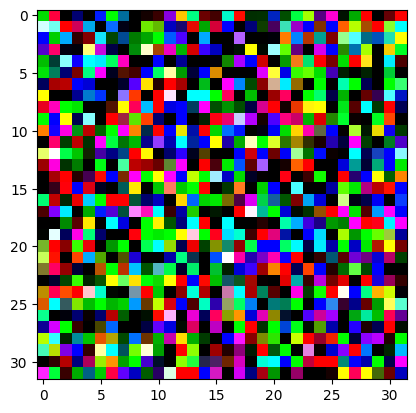

In [86]:
x = torch.randn(1,3072)

plt.imshow(x.reshape(3,32,32).permute(1, 2, 0).detach().numpy())

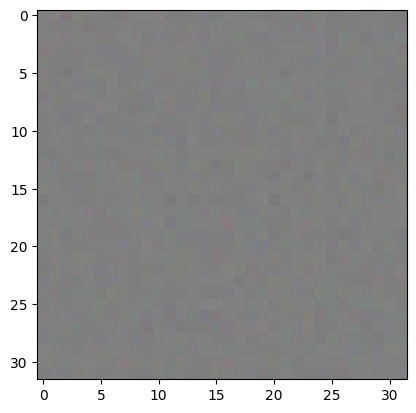

In [88]:
# Dimension Testing

out = AutoEnc(x)

out.shape
# https://stackoverflow.com/a/55196345/18071854
plt.imshow(out.reshape(3,32,32).permute(1, 2, 0).detach().numpy())

In [89]:
# Training Loop
losses = []
outputs = []
epoch = 1

size = len(train_loader)


for epoch in range(epochs):
    for idx, (image, label) in enumerate(train_loader):
        
        # Flattening the images to (batch_size, 784)
        image = image.reshape(-1,3*32*32)
        
        # Reconstruction of the Autoencoder
        reconstrution = AutoEnc(image)

        # Loss function
        calculated_loss = loss_fn(reconstrution, image)
        losses.append(calculated_loss)

        # Optimization
        optim.zero_grad()
        calculated_loss.backward()

        optim.step()

        if idx % 100 == 0:
            loss, current = calculated_loss.item(), (idx + 1) * len(train_loader.dataset)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    outputs.append((epochs, image, reconstrution))

0
loss: 0.667887  [   64/  782]
loss: 0.361606  [ 6464/  782]
loss: 0.336010  [12864/  782]
loss: 0.358831  [19264/  782]
loss: 0.362822  [25664/  782]
loss: 0.346700  [32064/  782]
loss: 0.388967  [38464/  782]
loss: 0.352257  [44864/  782]
1
loss: 0.284596  [   64/  782]
loss: 0.351445  [ 6464/  782]
loss: 0.287675  [12864/  782]
loss: 0.304216  [19264/  782]
loss: 0.339203  [25664/  782]
loss: 0.333607  [32064/  782]
loss: 0.303985  [38464/  782]
loss: 0.331976  [44864/  782]
2
loss: 0.332517  [   64/  782]
loss: 0.279538  [ 6464/  782]
loss: 0.322343  [12864/  782]
loss: 0.332359  [19264/  782]
loss: 0.304694  [25664/  782]
loss: 0.288356  [32064/  782]
loss: 0.283217  [38464/  782]
loss: 0.269207  [44864/  782]
3
loss: 0.280996  [   64/  782]
loss: 0.329573  [ 6464/  782]
loss: 0.327647  [12864/  782]
loss: 0.304230  [19264/  782]
loss: 0.269932  [25664/  782]
loss: 0.294453  [32064/  782]
loss: 0.271006  [38464/  782]
loss: 0.293122  [44864/  782]
4
loss: 0.324534  [   64/  782]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


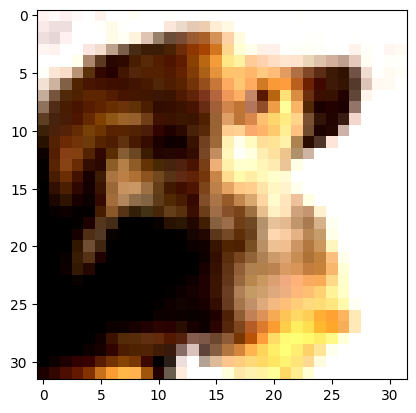

In [142]:
images = outputs[1][1].view(16, 3, 32, 32)
# plt.imshow(images[5,0,:,:])

# plt.imshow(images[5,:,:,:].permute(0,2,3,1))

img = images[9,:,:,:]

img_permutated = img.permute(1,2,0)

plt.imshow(img_permutated)


In [137]:
xs = np.arange(0,len(losses))

ys = [y.detach().numpy() for y in losses]

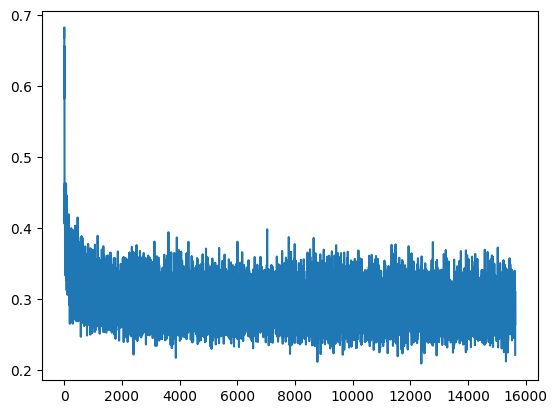

In [138]:
plt.plot(xs,ys)